<a href="https://colab.research.google.com/github/AntonThai2022/ML/blob/main/TVModel_start_stop__finished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all required modules
import numpy as np
import csv
import requests
import random
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Mount google drive in filesystem to persist store files
from google.colab import drive
drive.mount('/content/drive')
DIR_PATH = '/content/drive/MyDrive/'

MessageError: ignored

In [ ]:
def get_data_set_from_csv(file_name):
    """Function for loading raw data from google drive,
    data stares in csv format"""
    with open(file_name, encoding='utf-8', errors='ignore') as csv_file:
        data_X = []
        data_Y = []
        csv_reader = csv.reader(csv_file, delimiter=';')
        for row in csv_reader:
            data_X.append(row[2])
            data_Y.append(row[3])
        return data_X, data_Y

In [ ]:
x_data_raw, y_data_raw = get_data_set_from_csv(DIR_PATH + "tv.csv") # Load raw data

In [ ]:
# Use random.shuffle to shuffle input data, shuffle parallel to lists
c = list(zip(x_data_raw, y_data_raw))
random.shuffle(c)
x_data_raw, y_data_raw = zip(*c)

In [ ]:
# Define list of symbols can be used in input data
PRINTABLE = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'
RUSSIAN = 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
SPECIAL = '–'  # !symbol U+2013
SYMBOLS = PRINTABLE + RUSSIAN + SPECIAL

In [ ]:
# Build dictionary to map input symbols to vectors
token_index = {}; i = 0
for line in SYMBOLS:
    for char in line:
        if char not in token_index:
            token_index[char] = i
            i = i + 1

quantity_tokens = len(token_index)
# Reverse-lookup token index to decode sequence back to something readable
reverse_input_char_index = { i: char for (char, i) in token_index.items()  }

In [ ]:
NUM_CLASSES = 82  # 82 MAGIC NUMBER !!! Maximum position number plus one of Model name substring in data set.
# You have to change this in production system depend on assumption about input data.

In [ ]:
# Save dictionaty
with open(DIR_PATH + 'token_index.pkl', 'wb') as f:
    pickle.dump(token_index, f)

In [ ]:
# Restore dictionary
with open(DIR_PATH + 'token_index.pkl', 'rb') as f:
    token_index = pickle.load(f)
quantity_tokens = len(token_index)

In [ ]:
# Split the data into train, validation and test date
x_train_raw = x_data_raw[:20000]
y_train_raw = y_data_raw[:20000]

x_val_raw = x_data_raw[20000:22000]
y_val_raw = y_data_raw[20000:22000]

x_test_raw = x_data_raw[22000:]
y_test_raw = y_data_raw[22000:]



Get max length of input data

In [ ]:
def build_data_for_model(x_data, y_data, token2index_dict):
    """Build numpy tensors from input data, return input tensor for lstm and labels for output data"""
    input_texts_numerical_representation = []

    # Build numerical representation of string
    for text in x_data:
        input_texts_numerical_representation.append( [token2index_dict[token] for token in text] )

    # Complement the sequence to the equal length
    input_texts_numerical_representation = pad_sequences( input_texts_numerical_representation, maxlen=130, padding='post', value=token2index_dict[' '] )

    x_data_np = np.zeros( (len(x_data), len(input_texts_numerical_representation[0]), len(token2index_dict) ), dtype='float32')

    # Build one-hot encoding tensor from the input test
    for i, input_text in enumerate(input_texts_numerical_representation):
        for t, char_code in enumerate(input_text):
            x_data_np[i, t, char_code] = 1.
        # encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.

    labels_start = [ x.find(y) for x, y in zip(x_data, y_data) ]   # Get the position of the first and last symbols of substrings
    labels_stop = [first_symbol + len(substring) for first_symbol, substring in zip(labels_start, y_data)] # Traditionally, we point the character following the last

    # Create one-hot encodings vectors for labels
    categorical_labels_start = to_categorical(labels_start, num_classes=NUM_CLASSES)
    categorical_labels_stop = to_categorical(labels_stop, num_classes=NUM_CLASSES)

    return x_data_np, categorical_labels_start, categorical_labels_stop

In [ ]:
# Build train, validation and test date in tensor form
x_train, y_start_train, y_stop_train, = build_data_for_model(x_train_raw, y_train_raw, token_index)
x_val, y_start_val, y_stop_val = build_data_for_model(x_val_raw, y_val_raw, token_index)
x_test, y_start_test, y_stop_test = build_data_for_model(x_test_raw, y_test_raw, token_index)

In [ ]:
np.save(DIR_PATH + 'x_train.npy', x_train)
np.save(DIR_PATH + 'y_start_train.npy', y_start_train)
np.save(DIR_PATH + 'y_stop_train.npy', y_stop_train)

np.save(DIR_PATH + 'x_val.npy', x_val)
np.save(DIR_PATH + 'y_start_val.npy', y_start_val)
np.save(DIR_PATH + 'y_stop_val.npy', y_stop_val)

np.save(DIR_PATH + 'x_test.npy', x_test)
np.save(DIR_PATH + 'y_start_test.npy', y_start_test)
np.save(DIR_PATH + 'y_stop_test.npy', y_stop_test)

In [ ]:
x_train = np.load(DIR_PATH + 'x_train.npy')
y_start_train = np.load(DIR_PATH + 'y_start_train.npy')
y_stop_train = np.load(DIR_PATH + 'y_stop_train.npy')

x_val = np.load(DIR_PATH + 'x_val.npy')
y_start_val = np.load(DIR_PATH + 'y_start_val.npy')
y_stop_val = np.load(DIR_PATH + 'y_stop_val.npy')

x_test = np.load(DIR_PATH + 'x_test.npy')
y_start_test = np.load(DIR_PATH + 'y_start_test.npy')
y_stop_test = np.load(DIR_PATH + 'y_stop_test.npy')

quantity_tokens = x_test.shape[2]

Filling input data with spaces

In [ ]:
batch_size =  128 # define the batch size for training
epochs = 200 # define the number of epoch for training
latent_dim = 256 #define the dimensionality of the LSTM

In [ ]:
# Define the model
inputs = Input(shape=(None, quantity_tokens), name='input')
lstm_1 = LSTM(latent_dim, return_state=True, name='lstm_1')
batch_norm = tf.keras.layers.BatchNormalization()

start_output = Dense(NUM_CLASSES, activation='softmax', name='start_output')
stop_output = Dense(NUM_CLASSES, activation='softmax', name='stop_output')

lstm_outputs, _, _ = lstm_1(inputs)
batch_norm_outputs = batch_norm(lstm_outputs)

outputs_1 = start_output(batch_norm_outputs)
outputs_2 = stop_output(batch_norm_outputs)

model = Model(inputs, [outputs_1, outputs_2])

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

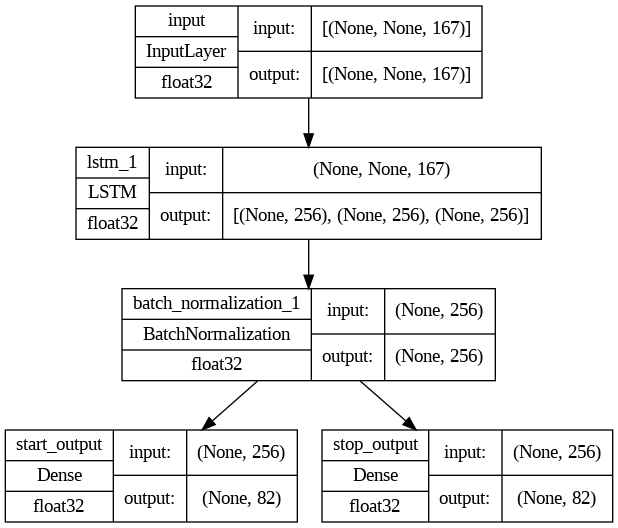

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/model_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_stop_output_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
print(x_train.shape)
print(y_start_train.shape)
print(y_stop_train.shape)

print(x_val.shape)
print(y_start_val.shape)
print(y_stop_val.shape)

print(x_test.shape)
print(y_start_test.shape)
print(y_stop_test.shape)

(20000, 130, 167)
(20000, 82)
(20000, 82)
(2000, 130, 167)
(2000, 82)
(2000, 82)
(7999, 130, 167)
(7999, 82)
(7999, 82)


In [ ]:
#Train the model
history = model.fit(x_train, [y_start_train, y_stop_train],
          batch_size=2048,
          epochs=600,
          #validation_split=0.2,
          validation_data=(x_val, [y_start_val, y_stop_val]),
          callbacks=[model_checkpoint_callback])

Epoch 1/600
10/10 [==============================] - 12s 384ms/step - loss: 8.6038 - start_output_loss: 4.2783 - stop_output_loss: 4.3255 - start_output_accuracy: 0.3302 - stop_output_accuracy: 0.1266 - val_loss: 7.8587 - val_start_output_loss: 3.8221 - val_stop_output_loss: 4.0367 - val_start_output_accuracy: 0.3580 - val_stop_output_accuracy: 0.1410
Epoch 2/600
10/10 [==============================] - 3s 300ms/step - loss: 8.0462 - start_output_loss: 3.9634 - stop_output_loss: 4.0828 - start_output_accuracy: 0.3617 - stop_output_accuracy: 0.1370 - val_loss: 6.5450 - val_start_output_loss: 2.9710 - val_stop_output_loss: 3.5740 - val_start_output_accuracy: 0.1165 - val_stop_output_accuracy: 0.0995
Epoch 3/600
10/10 [==============================] - 3s 304ms/step - loss: 7.5986 - start_output_loss: 3.6629 - stop_output_loss: 3.9356 - start_output_accuracy: 0.2011 - stop_output_accuracy: 0.1103 - val_loss: 6.3459 - val_start_output_loss: 2.8798 - val_stop_output_loss: 3.4661 - val_start

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
model.save("/content/drive/MyDrive/tv_model_pred.h5")

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/tv_model_pred.h5")

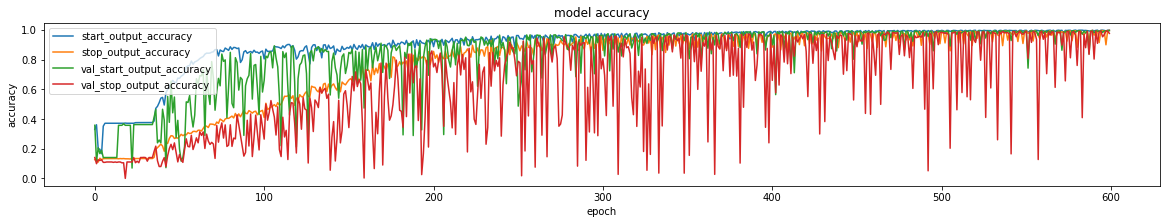

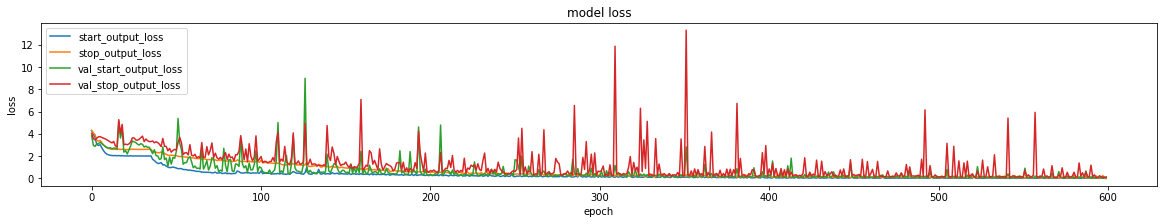

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(history.history['start_output_accuracy'])
plt.plot(history.history['stop_output_accuracy'])
plt.plot(history.history['val_start_output_accuracy'])
plt.plot(history.history['val_stop_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_output_accuracy', 'stop_output_accuracy', 'val_start_output_accuracy', 'val_stop_output_accuracy'], loc='upper left')
plt.show()


plt.plot(history.history['start_output_loss'])
plt.plot(history.history['stop_output_loss'])
plt.plot(history.history['val_start_output_loss'])
plt.plot(history.history['val_stop_output_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_output_loss', 'stop_output_loss', 'val_start_output_loss', 'val_stop_output_loss'], loc='upper left')
plt.show()

Тестиру

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, [y_start_test, y_stop_test], batch_size=128 * 4)
print("test loss, test acc:", results)

print("Evaluate on train data")
results = model.evaluate(x_train, [y_start_train, y_stop_train], batch_size=128 * 4)
print("train loss, train acc:", results)

print("Evaluate on val data")
results = model.evaluate(x_val, [y_start_val, y_stop_val], batch_size=128 * 4)
print("val loss, val acc:", results)

Evaluate on test data
16/16 [==============================] - 27s 2s/step - loss: 0.1295 - start_output_loss: 0.0330 - stop_output_loss: 0.0965 - start_output_accuracy: 0.9965 - stop_output_accuracy: 0.9925
test loss, test acc: [0.12945647537708282, 0.03297673910856247, 0.09647972881793976, 0.9964995384216309, 0.992499053478241]
Evaluate on train data
40/40 [==============================] - 61s 2s/step - loss: 0.0771 - start_output_loss: 0.0259 - stop_output_loss: 0.0512 - start_output_accuracy: 0.9969 - stop_output_accuracy: 0.9941
train loss, train acc: [0.07710107415914536, 0.02590973861515522, 0.05119132995605469, 0.9969499707221985, 0.9940500259399414]
Evaluate on val data
4/4 [==============================] - 5s 1s/step - loss: 0.0520 - start_output_loss: 0.0194 - stop_output_loss: 0.0325 - start_output_accuracy: 0.9980 - stop_output_accuracy: 0.9965
val loss, val acc: [0.05196806788444519, 0.019429847598075867, 0.03253822401165962, 0.9980000257492065, 0.9965000152587891]


In [ ]:
def predict(s):
    x_input_seq = [s]
    y_input_seq = ''
    input_seq, _, _ = build_data_for_model(x_input_seq, y_input_seq, token_index)
    prediction = model.predict(input_seq, verbose=0)
    prediction_start = np.argmax(prediction[0][0, :])
    prediction_stop = np.argmax(prediction[1][0, :])
    return prediction_start, prediction_stop

In [ ]:
X_EVALUATION_SET = x_data_raw
Y_EVALUATION_SET = y_data_raw

X_EVALUATION_SET = x_data_raw
Y_EVALUATION_SET = y_data_raw

indexes = [random.randrange(0, len(X_EVALUATION_SET)) for _ in range(30) ]
for seq_index in indexes:
    #take one sequence (part of the training set) for trying out decoding.
    prediction_start, prediction_stop = predict(X_EVALUATION_SET[seq_index])
    print('Input      :' + X_EVALUATION_SET[seq_index])
    print('Prediction :' + X_EVALUATION_SET[seq_index][prediction_start: prediction_stop] )
    print('Right      :' + Y_EVALUATION_SET[seq_index])
    print()

Input      :LG 47LE5510 47
Prediction :47LE5510
Right      :47LE5510

Input      :Philips 32PFL3018K
Prediction :32PFL3018K
Right      :32PFL3018K

Input      :LG 27TK600V
Prediction :27TK600V
Right      :27TK600V

Input      :Samsung UE78JS9502T
Prediction :UE78JS9502T
Right      :UE78JS9502T

Input      :SUPRA STV-LC4215DF
Prediction :STV-LC4215DF
Right      :STV-LC4215DF

Input      :Samsung CS-29Z47ZQQ 29
Prediction :CS-29Z47ZQQ
Right      :CS-29Z47ZQQ

Input      :Samsung SP-54J7PFR 54
Prediction :SP-54J7PFR
Right      :SP-54J7PFR

Input      :Skyworth 40E2AS 40 (2018)
Prediction :40E2AS
Right      :40E2AS

Input      :Philips 40PFL6636H
Prediction :40PFL6636H
Right      :40PFL6636H

Input      :Philips 47PFK7179
Prediction :47PFK7179
Right      :47PFK7179

Input      :DEXP F22D7100E 21.5 (2017)
Prediction :F22D7100E
Right      :F22D7100E

Input      :LG 55UQ76003LD
Prediction :55UQ76003LD
Right      :55UQ76003LD

Input      :Thomson T55FSE1170
Prediction :T55FSE1170
Right      :T